<a href="https://colab.research.google.com/github/rufoabrahamguyo/Machine-learning-codes/blob/main/corona%20pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_curve,
    auc,
    confusion_matrix
)
from sklearn.tree import plot_tree

# Load the data
df = pd.read_csv('coronavirusdataset.csv')
print("Dataset loaded. Shape:", df.shape)


Dataset loaded. Shape: (7294, 45)


In [9]:
print(df.head())
print(df.info())
print(df['covid19_test_results'].value_counts(dropna=False))


   batch_date                     test_name swab_type covid19_test_results  \
0  2020-10-20               SARS-CoV-2, NAA     Nasal             Negative   
1  2020-10-20  COVID-19 PCR External Result     Nasal             Negative   
2  2020-10-20       Rapid COVID-19 PCR Test     Nasal             Negative   
3  2020-10-20       Rapid COVID-19 PCR Test     Nasal             Negative   
4  2020-10-20       Rapid COVID-19 PCR Test     Nasal             Negative   

   age  high_risk_exposure_occupation high_risk_interactions  diabetes    chd  \
0   39                          False                    NaN     False  False   
1   56                          False                    NaN     False  False   
2   35                          False                    NaN     False  False   
3   37                          False                    NaN     False  False   
4   42                          False                    NaN     False  False   

     htn  ...  headache  loss_of_smell  loss

In [10]:
irrelevant = [
    'batch_date', 'test_name', 'swab_type', 'rapid_flu_results',
    'rapid_strep_results', 'cxr_findings', 'cxr_impression',
    'cxr_label', 'cxr_link'
]
df.drop(columns=[c for c in irrelevant if c in df.columns], inplace=True)
print("After dropping:", df.shape)


After dropping: (7294, 36)


In [11]:
# a) Drop rows with >30% missing
df.dropna(thresh=0.7 * df.shape[1], inplace=True)

# b) Numeric median imputation
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
for c in num_cols:
    df[c].fillna(df[c].median(), inplace=True)

# c) Categorical mode imputation
cat_cols = df.select_dtypes(include=['object']).columns
for c in cat_cols:
    df[c].fillna(df[c].mode()[0], inplace=True)

print("Missing values remaining:", df.isnull().sum().sum())


Missing values remaining: 0


/tmp/ipython-input-11-1486213639.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[c].fillna(df[c].median(), inplace=True)
/tmp/ipython-input-11-1486213639.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

In [12]:
le = LabelEncoder()
df['covid19_test_results'] = le.fit_transform(df['covid19_test_results'])

bool_cols = df.select_dtypes(include=['bool']).columns
df[bool_cols] = df[bool_cols].astype(int) if len(bool_cols)>0 else df[bool_cols]

print("Classes:", list(le.classes_))


Classes: ['Negative', 'Positive']


In [13]:
X = df.drop(columns=['covid19_test_results'])
y = df['covid19_test_results']

X = pd.get_dummies(X, columns=X.select_dtypes(include=['object']).columns, drop_first=True)
print("Features shape:", X.shape)


Features shape: (1922, 37)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train:", X_train.shape, "Test:", X_test.shape)
print("Train balance:\n", y_train.value_counts(normalize=True))


Train: (1537, 37) Test: (385, 37)
Train balance:
 covid19_test_results
0    0.992193
1    0.007807
Name: proportion, dtype: float64


In [15]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

rf.fit(X_train, y_train)
gb.fit(X_train, y_train)


GradientBoostingClassifier(random_state=42)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Random Forest ###
Accuracy: 0.9922
              precision    recall  f1-score   support

    Negative       0.99      1.00      1.00       382
    Positive       0.00      0.00      0.00         3

    accuracy                           0.99       385
   macro avg       0.50      0.50      0.50       385
weighted avg       0.98      0.99      0.99       385

ROC AUC: 0.5497


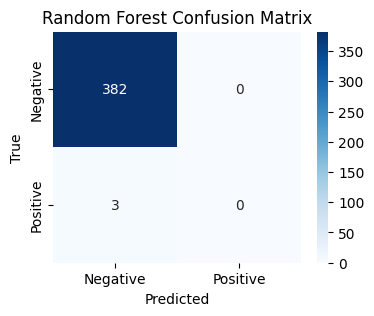

### Gradient Boosting ###
Accuracy: 0.9896
              precision    recall  f1-score   support

    Negative       0.99      1.00      0.99       382
    Positive       0.00      0.00      0.00         3

    accuracy                           0.99       385
   macro avg       0.50      0.50      0.50       385
weighted avg       0.98      0.99      0.99       385

ROC AUC: 0.5515


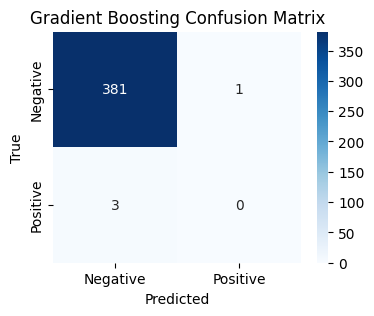

In [16]:
def evaluate(name, model):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=le.classes_)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    print(f"### {name} ###")
    print("Accuracy:", round(acc,4))
    print(report)
    print("ROC AUC:", round(roc_auc,4))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return acc, fpr, tpr, roc_auc

acc_rf, fpr_rf, tpr_rf, auc_rf = evaluate("Random Forest", rf)
acc_gb, fpr_gb, tpr_gb, auc_gb = evaluate("Gradient Boosting", gb)


In [17]:

summary_df = pd.DataFrame({
    'Model': ['Random Forest','Gradient Boosting'],
    'Accuracy': [acc_rf, acc_gb],
    'ROC AUC': [auc_rf, auc_gb]
})
from IPython.display import display
display(summary_df.style.format({"Accuracy":"{:.2f}","ROC AUC":"{:.2f}"}))


,Model,Accuracy,ROC AUC
0,Random Forest,0.99,0.55
1,Gradient Boosting,0.99,0.55


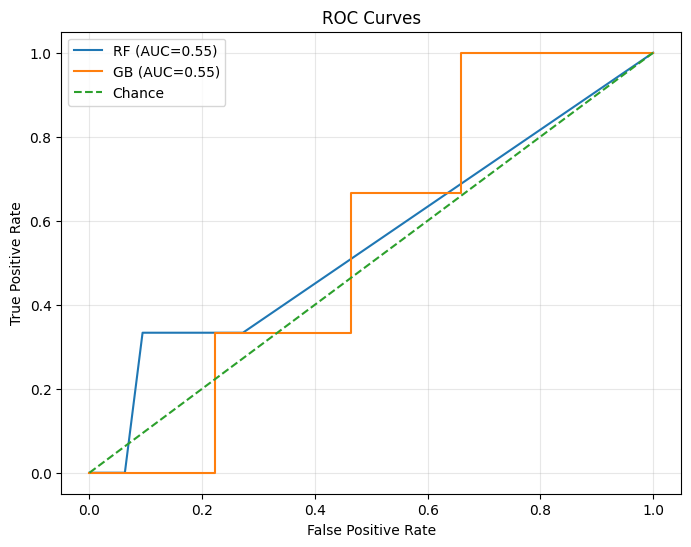

In [18]:
plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label=f'RF (AUC={auc_rf:.2f})')
plt.plot(fpr_gb, tpr_gb, label=f'GB (AUC={auc_gb:.2f})')
plt.plot([0,1],[0,1],'--', label='Chance')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


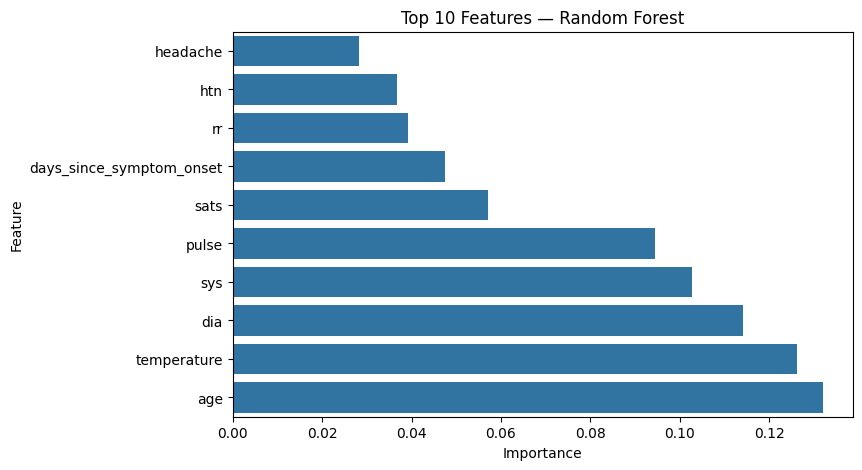

Random Forest top features:
 age                         0.132038
temperature                 0.126113
dia                         0.114009
sys                         0.102605
pulse                       0.094493
sats                        0.057008
days_since_symptom_onset    0.047409
rr                          0.039266
htn                         0.036751
headache                    0.028356
dtype: float64 



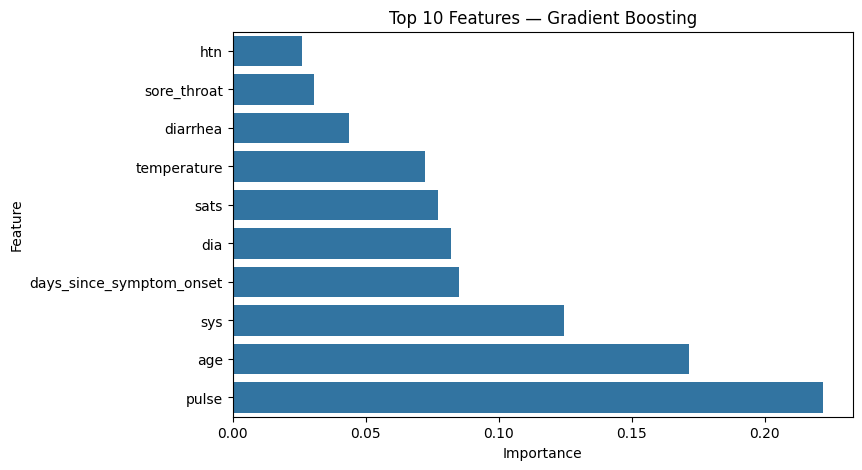

Gradient Boosting top features:
 pulse                       0.221923
age                         0.171365
sys                         0.124670
days_since_symptom_onset    0.085074
dia                         0.082148
sats                        0.077227
temperature                 0.072201
diarrhea                    0.043747
sore_throat                 0.030418
htn                         0.026165
dtype: float64 



In [19]:
for name, model in [("Random Forest", rf), ("Gradient Boosting", gb)]:
    imp = pd.Series(model.feature_importances_, index=X.columns)
    imp = imp.sort_values(ascending=False).head(10)
    plt.figure(figsize=(8,5))
    sns.barplot(x=imp.values, y=imp.index)
    plt.title(f'Top 10 Features — {name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.gca().invert_yaxis()
    plt.show()
    print(f"{name} top features:\n", imp, "\n")


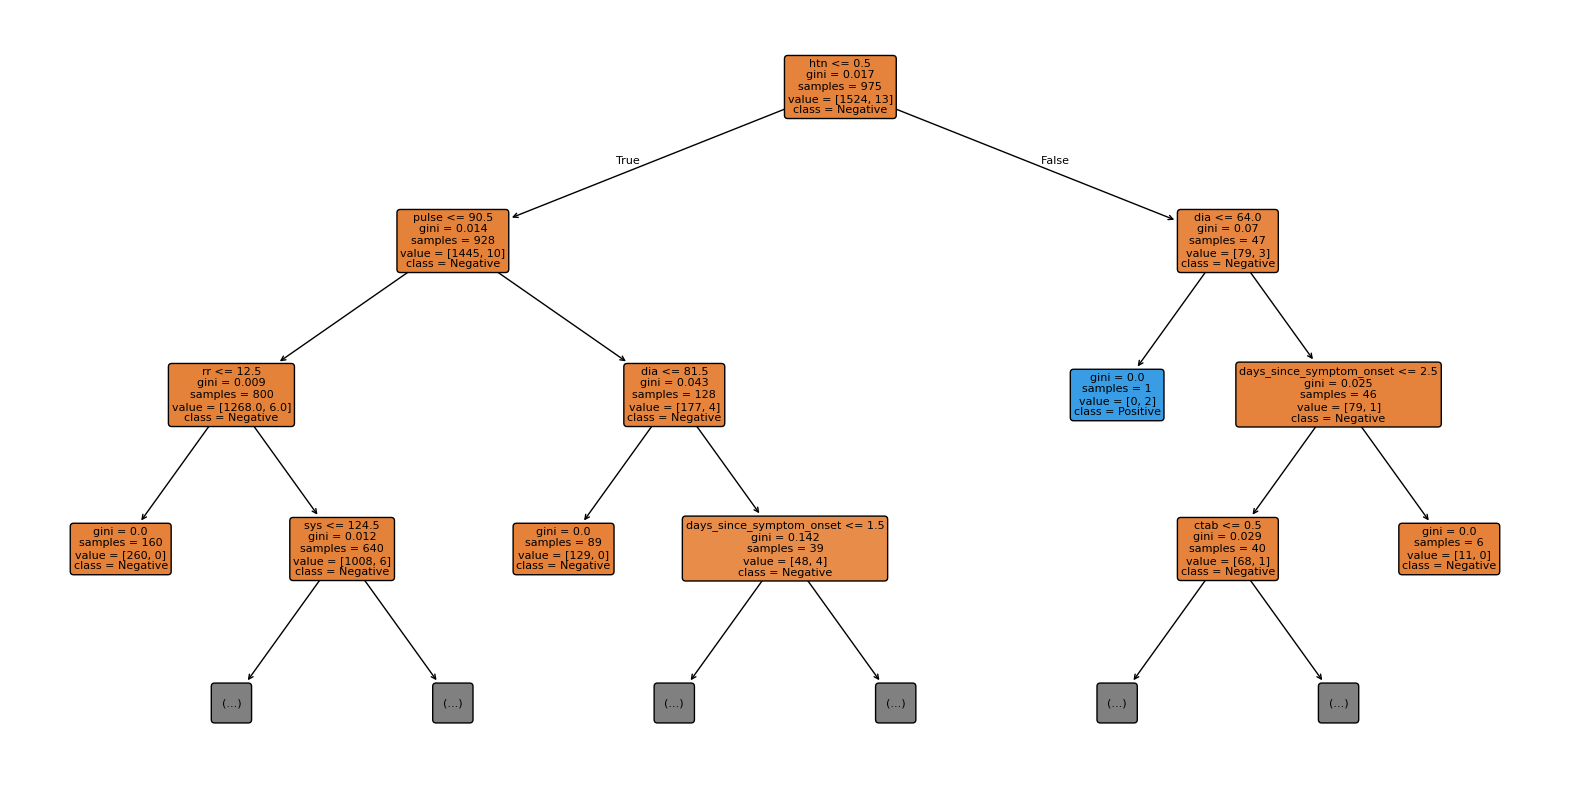

In [20]:
plt.figure(figsize=(20,10))
plot_tree(
    rf.estimators_[0],
    feature_names=X.columns,
    class_names=le.classes_,
    filled=True, rounded=True,
    max_depth=3, fontsize=8
)
plt.show()
